<a href="https://colab.research.google.com/github/DataSnek/ML-Project/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

# Auto-load all files
# Mounting drive to avoid manual uploads
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# reducing the memory to allow scalable joins and faster experimentation
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df

In [30]:
# Unzipping the data
# (Assumes your file is at /content/drive/My Drive/Data)
# We use -n to avoid overwriting if it already exists
if not os.path.exists('/content/dataset'):
    !unzip -n -q "/content/drive/My Drive/Data" -d "/content/dataset"

In [31]:
# Extract variables
print("Loading CSVs...")
orders = pd.read_csv('/content/dataset/orders.csv')
products = pd.read_csv('/content/dataset/products.csv')
departments = pd.read_csv('/content/dataset/departments.csv')
aisles = pd.read_csv('/content/dataset/aisles.csv')
order_products_prior = pd.read_csv('/content/dataset/order_products__prior.csv')
order_products_train = pd.read_csv('/content/dataset/order_products__train.csv')
print("Data loaded.")

Loading CSVs...
Data loaded.


In [32]:
# reducing the memory
orders = reduce_mem_usage(orders)
products = reduce_mem_usage(products)
departments = reduce_mem_usage(departments)
aisles = reduce_mem_usage(aisles)
order_products_prior = reduce_mem_usage(order_products_prior)
order_products_train = reduce_mem_usage(order_products_train)
print("Memory reduction complete.")

Memory reduction complete.


In [33]:
# merging the tables
# Merge safely to create the full product info
products_full = (
    products
    .merge(aisles, on="aisle_id", how="left")
    .merge(departments, on="department_id", how="left")
)

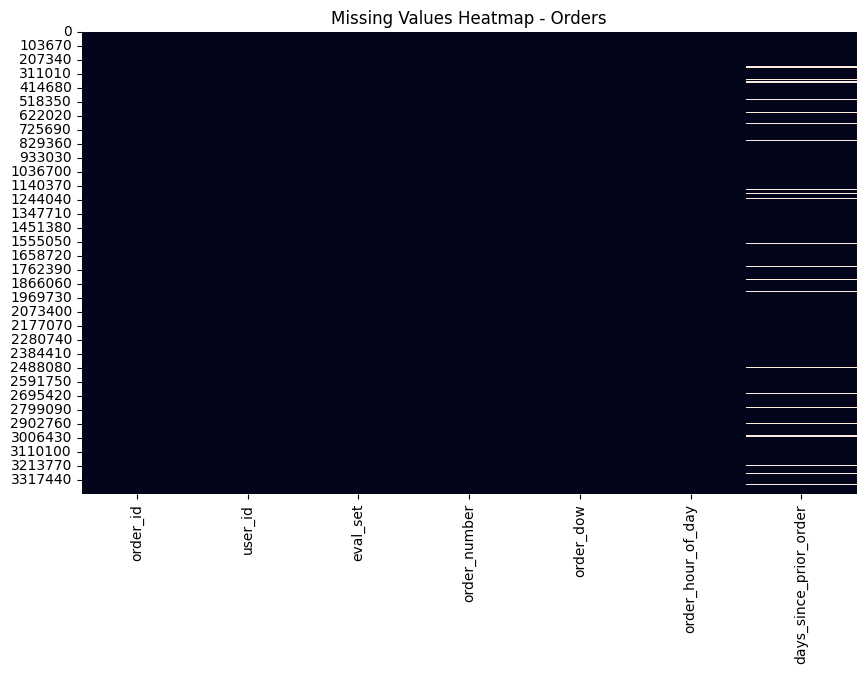

In [34]:
# missing value visulisation
plt.figure(figsize=(10, 6))
sns.heatmap(orders.isnull(), cbar=False)
plt.title("Missing Values Heatmap - Orders")
plt.show()

In [35]:
# Imputation was chosen as NaN indicates the first order for the user (0 days)
orders["days_since_prior_order"] = orders["days_since_prior_order"].fillna(0)

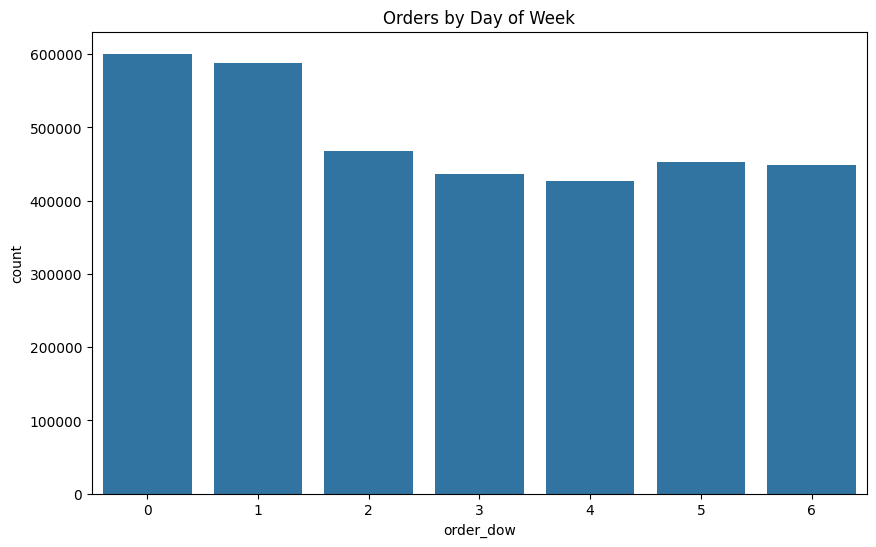

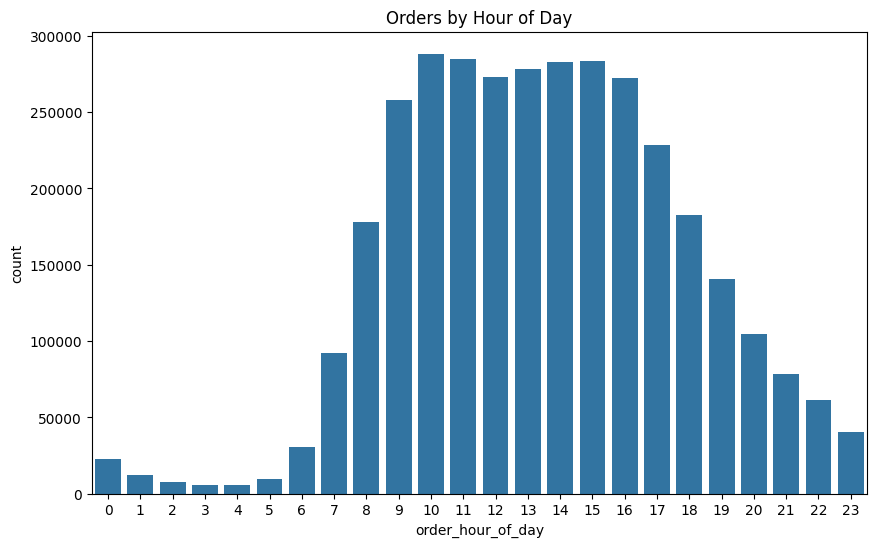

In [36]:
# A Day
plt.figure(figsize=(10, 6))
sns.countplot(x="order_dow", data=orders)
plt.title("Orders by Day of Week")
plt.show()

# hour
plt.figure(figsize=(10, 6))
sns.countplot(x="order_hour_of_day", data=orders)
plt.title("Orders by Hour of Day")
plt.show()

Rows to plot: 10


/tmp/ipython-input-1779202202.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="product_name", x="count", data=top_products, palette='viridis')


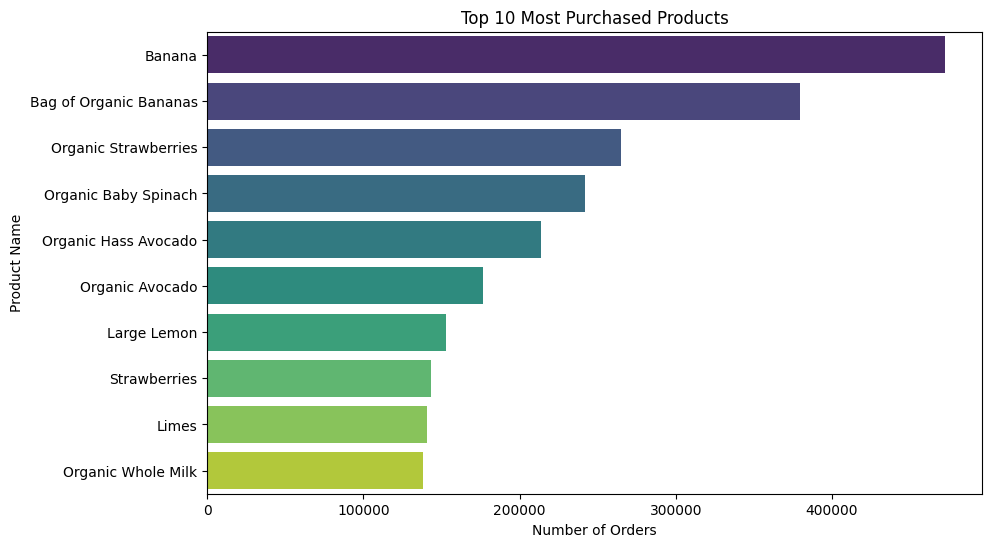

In [37]:
# Calculate the top 10
top_products_counts = order_products_prior["product_id"].value_counts().head(10).reset_index()
top_products_counts.columns = ['product_id', 'count']

# Merge with product names
top_products = top_products_counts.merge(products, on="product_id")

#  Convert 'product_name' from Category to String
# This stops the plot from trying to show hidden categories
top_products['product_name'] = top_products['product_name'].astype(str)

#Sanity Check: Ensure we only have 10 rows
print(f"Rows to plot: {top_products.shape[0]}") # Should say 10
if top_products.shape[0] > 10:
    top_products = top_products.head(10) # Force limit if merge expanded it

#  Plot Cleanly
plt.figure(figsize=(10, 6))
sns.barplot(y="product_name", x="count", data=top_products, palette='viridis')
plt.title("Top 10 Most Purchased Products")
plt.xlabel("Number of Orders")
plt.ylabel("Product Name")
plt.show()

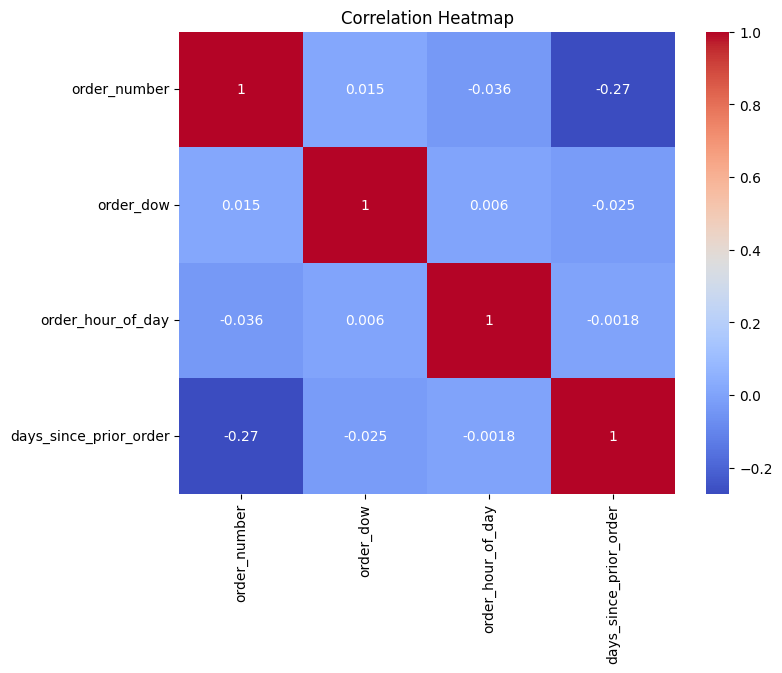

In [38]:
# correlation heatmap
corr_df = orders[["order_number", "order_dow", "order_hour_of_day", "days_since_prior_order"]]
plt.figure(figsize=(8,6))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [39]:
def check_data_integrity():
    print("--- Starting Sanity Checks ---\n")

    # CHECK IMPUTATION
    # We expect 0 missing values in days_since_prior_order now
    missing_days = orders['days_since_prior_order'].isnull().sum()
    assert missing_days == 0, f"FAILED: Found {missing_days} nulls in days_since_prior_order!"
    print(f" Imputation Check: PASSED (0 missing values)")

    # CHECK RANGES (Logical Consistency)
    # Days of week must be 0-6
    assert orders['order_dow'].min() >= 0 and orders['order_dow'].max() <= 6, "FAILED: order_dow out of range (0-6)"
    # Hours must be 0-23
    assert orders['order_hour_of_day'].min() >= 0 and orders['order_hour_of_day'].max() <= 23, "FAILED: Hour out of range (0-23)"
    # Days since prior order (max is usually 30 in this dataset)
    assert orders['days_since_prior_order'].max() <= 30, "FAILED: days_since_prior_order > 30 found"
    print(f" Logical Range Check: PASSED")

    #  CHECK MEMORY REDUCTION SAFETY
    # If reduction was too aggressive, IDs might become negative (overflow)
    assert orders['order_id'].min() > 0, "FAILED: Negative order_id found! Memory reduction corrupted data."
    assert products['product_id'].min() > 0, "FAILED: Negative product_id found!"
    print(f" Memory Safety Check: PASSED")

    #  CHECK REFERENTIAL INTEGRITY
    # Do we have products in orders that don't exist in the product table?
    unique_products_ordered = order_products_prior['product_id'].unique()
    unique_products_listed = products['product_id'].unique()
    # Check if all ordered products exist in product list
    # isin returns boolean, all() checks if they are all True
    assert np.isin(unique_products_ordered, unique_products_listed).all(), "FAILED: Found orders for product_ids that don't exist in products table!"
    print(f" Referential Integrity Check: PASSED")

    print("\n--- All Checks Passed. You are ready for Feature Engineering! ---")

check_data_integrity()

--- Starting Sanity Checks ---

 Imputation Check: PASSED (0 missing values)
 Logical Range Check: PASSED
 Memory Safety Check: PASSED
 Referential Integrity Check: PASSED

--- All Checks Passed. You are ready for Feature Engineering! ---


In [40]:
# Product-Level Features
print("Generating Product Features...")

# Group by product_id to get stats
prods = pd.DataFrame()
prods['orders'] = order_products_prior.groupby(order_products_prior.product_id).size().astype(np.int32)
prods['reorders'] = order_products_prior.groupby(order_products_prior.product_id)['reordered'].sum().astype(np.int32)
prods['reorder_rate'] = (prods['reorders'] / prods['orders']).astype(np.float32)

# Reset index to make product_id a column
products_features = prods.reset_index()

# Clean up
del prods
gc.collect()

print(f"Product features created. Shape: {products_features.shape}")
products_features.head()

Generating Product Features...
Product features created. Shape: (49677, 4)


,product_id,orders,reorders,reorder_rate
0,1,1852,1136,0.613391
1,2,90,12,0.133333
2,3,277,203,0.732852
3,4,329,147,0.446809
4,5,15,9,0.600000


In [41]:
#  User-Level Features
print("Generating User Features...")

#  Basic stats from 'orders' table (Total orders, Average days between)
users = orders[orders.eval_set == 'prior'].groupby('user_id').agg({
    'order_number': 'max',
    'days_since_prior_order': 'mean'
}).rename(columns={
    'order_number': 'user_total_orders',
    'days_since_prior_order': 'user_avg_days_between_orders'
})

#  Basket stats (Total items, Reorder ratio)
# We need to merge orders with prior products temporarily
user_products_temp = order_products_prior.merge(orders, on='order_id', how='left')

# Group by user to get total items bought and reordered
us = user_products_temp.groupby('user_id').agg({
    'product_id': 'count',
    'reordered': 'mean'
}).rename(columns={
    'product_id': 'user_total_items',
    'reordered': 'user_reorder_ratio'
})

#  Calculate Average Basket Size
us['user_avg_basket_size'] = (us['user_total_items'] / users['user_total_orders']).astype(np.float32)

# Combine A and B
users_features = users.merge(us, on='user_id', how='left').reset_index()

# Clean up massive temp table immediately
del user_products_temp, us, users
gc.collect()

print(f"User features created. Shape: {users_features.shape}")
users_features.head()

Generating User Features...
User features created. Shape: (206209, 6)


,user_id,user_total_orders,user_avg_days_between_orders,user_total_items,user_reorder_ratio,user_avg_basket_size
0,1,10,17.600000,59,0.694915,5.900000
1,2,14,14.142858,195,0.476923,13.928572
2,3,12,11.083333,88,0.625000,7.333333
3,4,5,11.000000,18,0.055556,3.600000
4,5,4,10.000000,37,0.378378,9.250000


In [42]:
# User-Product Interaction Features
print("Generating User-Product Features...")

# Create a merged table of users and products
# We only care about products the user has bought BEFORE (Candidate Generation)
uxp = order_products_prior.merge(orders, on='order_id', how='left')

# Group by [user, product] to get interaction stats
uxp_features = uxp.groupby(['user_id', 'product_id']).agg({
    'order_id': 'count' # How many times user bought this product
}).rename(columns={'order_id': 'uxp_total_bought'})

uxp_features = uxp_features.reset_index()

# Clean up
del uxp
gc.collect()

print(f"User-Product interaction features created. Shape: {uxp_features.shape}")
uxp_features.head()

Generating User-Product Features...
User-Product interaction features created. Shape: (13307953, 3)


,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [43]:
# Create Master DataFrame
print("Merging all features...")

#  Identify which users we need to predict for (Train/Test sets)
# We look at the 'orders' table to find the last order for each user
distinct_users = orders[orders.eval_set != 'prior'][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]

#  Merge with our Candidates (User-Product pairs)
# We perform a Right Join: We want all (User, Product) pairs, but ONLY for the users in distinct_users
data = uxp_features.merge(distinct_users, on='user_id', how='inner')

#  Add User Features
data = data.merge(users_features, on='user_id', how='left')

#  Add Product Features
data = data.merge(products_features, on='product_id', how='left')

print(f"Master features merged. Shape: {data.shape}")
data.head()

Merging all features...
Master features merged. Shape: (13307953, 14)


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,user_id,product_id,uxp_total_bought,order_id,eval_set,days_since_prior_order,user_total_orders,user_avg_days_between_orders,user_total_items,user_reorder_ratio,user_avg_basket_size,orders,reorders,reorder_rate
0,1,196,10,1187899,train,14.0,10,17.6,59,0.694915,5.9,35791,27791,0.776480
1,1,10258,9,1187899,train,14.0,10,17.6,59,0.694915,5.9,1946,1389,0.713772
2,1,10326,1,1187899,train,14.0,10,17.6,59,0.694915,5.9,5526,3603,0.652009
3,1,12427,10,1187899,train,14.0,10,17.6,59,0.694915,5.9,6476,4797,0.740735
4,1,13032,3,1187899,train,14.0,10,17.6,59,0.694915,5.9,3751,2465,0.657158


In [44]:
#  Create Target Labels (for Train set only)
print("Creating Target Variables...")

# Filter 'data' to keep only the training set rows
data_train = data[data.eval_set == 'train'].copy()

# Prepare the 'ground truth' from order_products_train
# We create a set of (user_id, product_id) that actually happened
# To do this, we need to attach user_id to order_products_train
train_orders_info = orders[['order_id', 'user_id']]
train_ground_truth = order_products_train.merge(train_orders_info, on='order_id', how='left')

# Create a simpler "index" column to match faster
# Creating a string key "user_product" is a quick way to check existence
data_train['key'] = data_train['user_id'].astype(str) + '_' + data_train['product_id'].astype(str)
train_ground_truth['key'] = train_ground_truth['user_id'].astype(str) + '_' + train_ground_truth['product_id'].astype(str)

# The Target: 1 if the key exists in ground truth, 0 otherwise
actual_reorders = set(train_ground_truth['key'])
data_train['reordered'] = data_train['key'].apply(lambda x: 1 if x in actual_reorders else 0)

# Drop the temp key
data_train = data_train.drop('key', axis=1)

print(f"Target variable created. Class distribution:\n{data_train['reordered'].value_counts()}")

Creating Target Variables...
Target variable created. Class distribution:
reordered
0    7645837
1     828824
Name: count, dtype: int64


In [45]:
# Clean up raw tables to free RAM for the model
del orders, order_products_prior, products_features, users_features, uxp_features
gc.collect()

# Save the final processed data
# This file is what you will load for Task 3 (Modeling)
data_train.to_pickle('/content/drive/My Drive/instacart_train_data.pkl')
print("Feature Engineering Complete. Data saved to Drive.")

Feature Engineering Complete. Data saved to Drive.
